In [1]:
# calculate the linear regression for each gridpoint and mean over the areas from the mask function
import xarray as xr
import matplotlib.pyplot as plt
import time
import numpy as np
import xarray as xr
import time
import numpy as np
import cartopy.crs as ccrs
import cartopy as cart
# import xclim as xc
import os
from matplotlib import rcParams
from memory_profiler import profile
from matplotlib.colors import BoundaryNorm
import matplotlib.ticker as mticker
import matplotlib.colors as mplcolors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean as cmo
import matplotlib.gridspec as gridspec
import pandas as pd
from matplotlib import rcParams
# own functions
import Plot.plotfunctions as plotfunc
import Calculation.humiditycalculation as humidcalc
import Calculation.trend_func as trends
import Calculation.save_detrend_deseason as sdd
import Calculation.heat_wave_indetification as hwi
import os
from memory_profiler import profile
import scipy.stats as stats
import scipy.signal as signal
import Calculation.mask_creation as mc

# from cartopy.mpl.geoaxes import GeoAxes
# GeoAxes._pcolormesh_patched = Axes.pcolormesh

homefolder = '/home/nniebaum/data_nils'
datafolder = '/data/user/nniebaum'
plotfolder = '/home/nniebaum/bachlor-thesis-code/Plots/'
areafolder = plotfolder + "Area/"
trendfolder = plotfolder + "Trends/"

# rcParams_area = {
#                 'figure.titlesize': 15,
#                 'axes.titlesize': 'x-large',
#                 'axes.labelsize': 'x-large',
#                 'xtick.labelsize': 'large',
#                 'ytick.labelsize': 'large',
#                 'hatch.linewidth' : 1.5,
#                 'hatch.color' : [0.4,0.4,0.4],
#                 'figure.facecolor':'w',
#                 'savefig.bbox': 'tight',
#                 'savefig.dpi': 400,
#                 'savefig.facecolor': 'w',
#                 'savefig.format': 'png',
#                 'savefig.pad_inches': 0.01,
#                 'savefig.transparent': False,
#                 }

plt.rcParams.update(plotfunc.rcParams_area)

In [2]:
data= xr.open_dataset(datafolder + '/New2_europe_full_daymax_masks_population_1900-01-01_2010-12-31.nc')

data.heatwave_mask_ydrunpctl_98_referenceperiod.sum()

# duration = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['duration']
# threshold = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['threshold']
# quantile = data.heatwave_mask_ydrunpctl_98_referenceperiod.attrs['quantile']

<xarray.DataArray 'heatwave_mask_ydrunpctl_98_referenceperiod' ()>
array(143670)

**Plot the histograms of swbgtX for heat wave definitions**

Text(0.5, 0, 'sWBGTX')

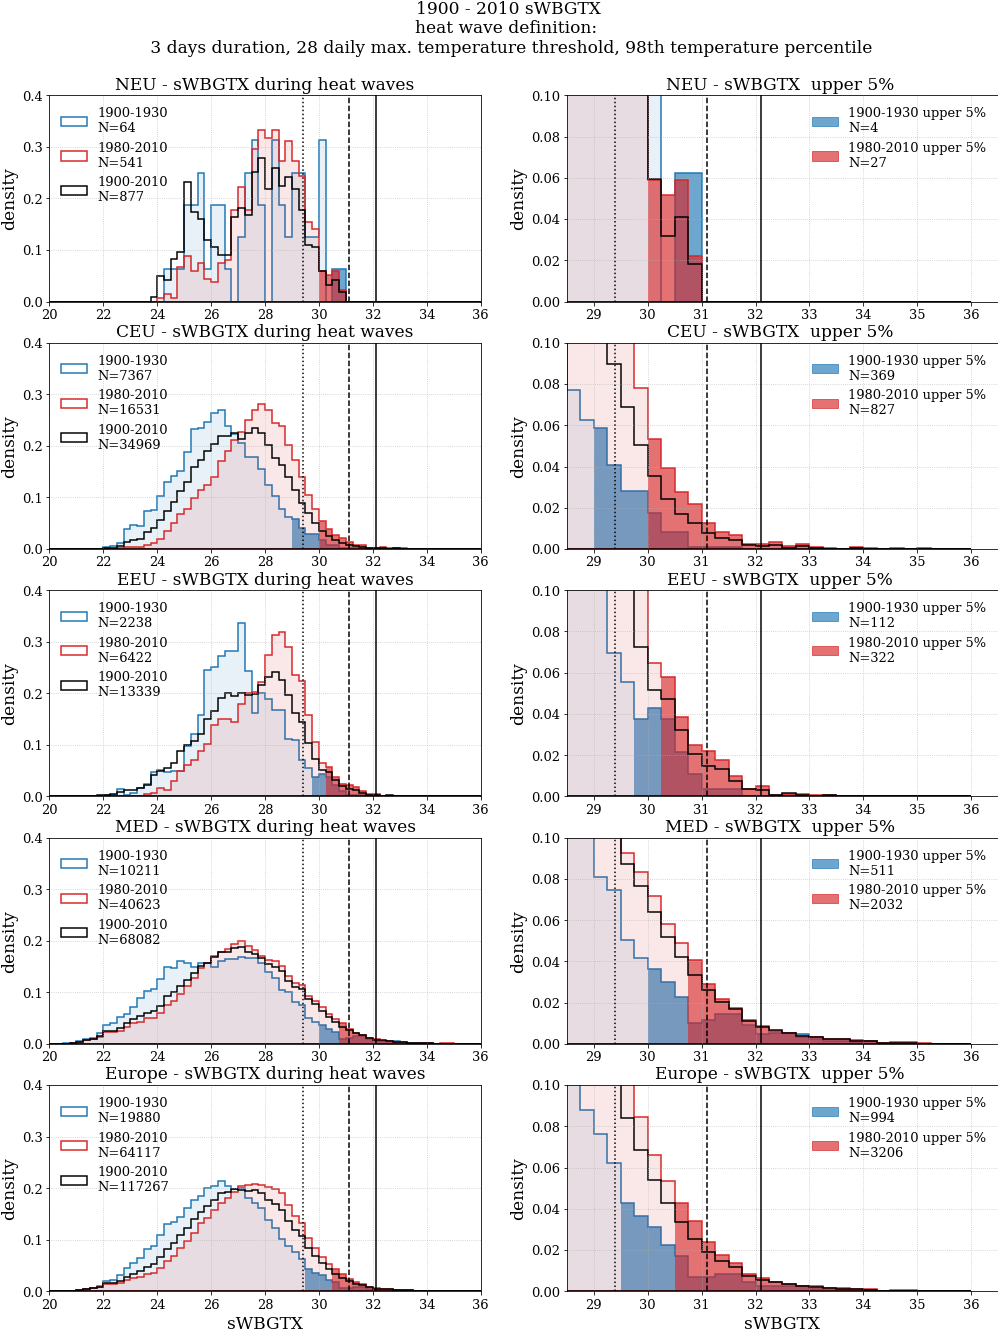

In [19]:
# ================== HISTOGRAMMS =================

regions = [('NEU', 16), ('CEU', 17) , ('EEU' , 18), ('MED' , 19), ("Europe", None)]


color = "tab:red"
header = 'mean temperature during heatwave'
ylabel = 'density'
xlabel = 'sWBGTX'
variable = "swbgt"
variable_long = "sWBGTX"
binwidth = 0.25
min_bins = 20
max_bins = 36

mask = data.heatwave_mask_ydrunpctl_98_referenceperiod
land_mask = data.mask_land
year_start = data.time[0].dt.strftime("%Y").values
year_end = data.time[-1].dt.strftime("%Y").values
figure_title = year_start + " - " + year_end + " {}\nheat wave definition: \n {:.0f} days duration, {:.0f} daily max. temperature threshold, {:.0f}th temperature percentile".format(variable_long, mask.attrs["duration"], mask.attrs['threshold'], mask.attrs['quantile']*100)
variable_long

# ========== PLOT ==============
density = True
first30 = slice("1900", "1930")
last30 = slice("1980", "2010")


def plot_timeslice(ax, data, timeslice, color, upper_label = False):

    # plot first 30 years
    selected = data.sel(time = timeslice).values.flatten()
    selected = selected[~np.isnan(selected)]
    upper_percentage = np.quantile(selected, 0.95)
    number_upper = sum(selected > upper_percentage)
    number_total  = len(selected)
    bins = np.arange(min_bins, max_bins + binwidth, binwidth)
    
    if not upper_label:
        label = "{}-{}\nN={}".format(timeslice.start, timeslice.stop, number_total)
        step = ax.hist(selected, bins = bins, color = color, histtype = 'stepfilled', alpha = 1, density = True, facecolor = "None", edgecolor = color, linewidth = 1.5, label = label)
        hist = ax.hist(selected, bins = bins, color = color, histtype = 'bar', alpha = 0.1, density = density, facecolor = color) 
    else :
        label = "{}-{} upper 5%\nN={}".format(timeslice.start, timeslice.stop, number_upper)
        step = ax.hist(selected, bins = bins, color = color, histtype = 'stepfilled', alpha = 1, density = True, facecolor = "None", edgecolor = color, linewidth = 1.5)
        hist = ax.hist(selected, bins = bins, color = color, histtype = 'bar', alpha = 0.1, density = density, facecolor = color)#, label = label)

    for thispatch in hist[2]:
        if thispatch.xy[0] - binwidth/2 >= upper_percentage :
            thispatch.set_facecolor(color)
            thispatch.set_alpha(0.65)
            filled_patch = thispatch
    
    return upper_percentage, number_total, number_upper, label


def plot_sample(ax, data, upper_label = False) :
    sample = data.values.flatten()
    sample = sample[~np.isnan(sample)]
    upper_percentage = np.quantile(sample, 0.95)
    number_upper = sum(sample > upper_percentage)
    number_total  = len(sample)
    bins = np.arange(min_bins, max_bins + binwidth, binwidth)    
    label = "1900-2010\nN={}".format(number_total)
    if upper_label:
        label = "1900-2010 upper 5%\nN={}".format(number_upper)
        
    N, bins, patches = ax.hist(sample, bins = bins, color = "tab:grey", histtype = 'stepfilled', alpha = 1, density = True, facecolor = "None", edgecolor = 'k', linewidth = 1.5, label = label)
    return number_total, patches


    
plt.rcParams['hatch.linewidth'] = 0.1
plt.rcParams['hatch.color'] = "k"
fig = plt.figure(figsize = (17,22)) 
fig.suptitle(figure_title, y = 0.94)
gs = gridspec.GridSpec(nrows = 5, ncols = 2)
    
idx = 0
for region in regions:

#     mask_russo = mask_russo_org.where(land_mask, other = False).where(mc.mask_region(mask_russo_org, region[1]), other = False)
    mask = data.heatwave_mask_ydrunpctl_98_referenceperiod.where(land_mask, other = False).where(mc.mask_region(mask, region[1]), other = False)

    # create the figure and the gridspecs


    ax0 = fig.add_subplot(gs[idx,0])
    ax1 = fig.add_subplot(gs[idx,1])
#     ax2 = fig.add_subplot(gs[1,0])
#     ax3 = fig.add_subplot(gs[1,1])
    # plot first 30 years 
    plot_data = data[variable].where(mask)

    first_res = plot_timeslice(ax = ax0, data = plot_data, timeslice = first30, color = "tab:blue")
    last_res = plot_timeslice(ax = ax0, data = plot_data, timeslice = last30, color = "tab:red")
    plot_sample(ax = ax0, data = plot_data)
    ax0.legend(loc = 'upper left')
    first_res = plot_timeslice(ax = ax1, data = plot_data, timeslice = first30, color = "tab:blue", upper_label = True)
    last_res = plot_timeslice(ax = ax1, data = plot_data, timeslice = last30, color = "tab:red", upper_label = True)
    plot_sample(ax = ax1, data = plot_data, upper_label = True)
    patches = []
    patches.append(mpatches.Patch(color='tab:blue', alpha = 0.65, label=first_res[-1]))
    patches.append(mpatches.Patch(color='tab:red', alpha = 0.65, label=last_res[-1]))
    lgd = ax1.legend(handles=patches, loc = 'upper right')
#     ax1.legend()
    
    ylim = list(ax1.get_xlim())
    ylim[0] = int(min([first_res[0], last_res[1]])) - 0.5
    ax1.set_xlim(ylim)
    ax1.set_ylim([0,0.10])
    ax0.set_ylim([0,0.4])
    ax0.set_xlim(20,36)
    ax1.set_xlim(28.5,36.5)
    ax0.set_title(region[0] + ' - ' + variable_long + ' during heat waves')

    ax1.set_title(region[0] + ' - ' + variable_long + '  upper 5% ')
#     both_variables(ax = ax1, data = data.swbgt.where(mask_russo))

#     both_variables(ax = ax2, data = hwmid.where(mask_dwd))
#     both_variables(ax = ax3, data = hwmid.where(mask_russo))

    for axs in [ax0,ax1]:
        axs.set_ylabel('density')
#         axs.set_xlabel('sWBGT')
        axs.grid()
        axs.axvline(29.4, color = 'k', linewidth = 1.5, linestyle = ':')
        axs.axvline(31.1, color = 'k', linewidth = 1.5, linestyle = '--')
        axs.axvline(32.1, color = 'k', linewidth = 1.5, linestyle = '-')


    idx += 1
    
ax0.set_xlabel(xlabel)
ax1.set_xlabel(xlabel)

In [20]:
fig.savefig(trendfolder + 'histograms_' + variable_long + '_density_ydrunpctl_98_referenceperiod.png')

Text(0.5, 0, 'TX')

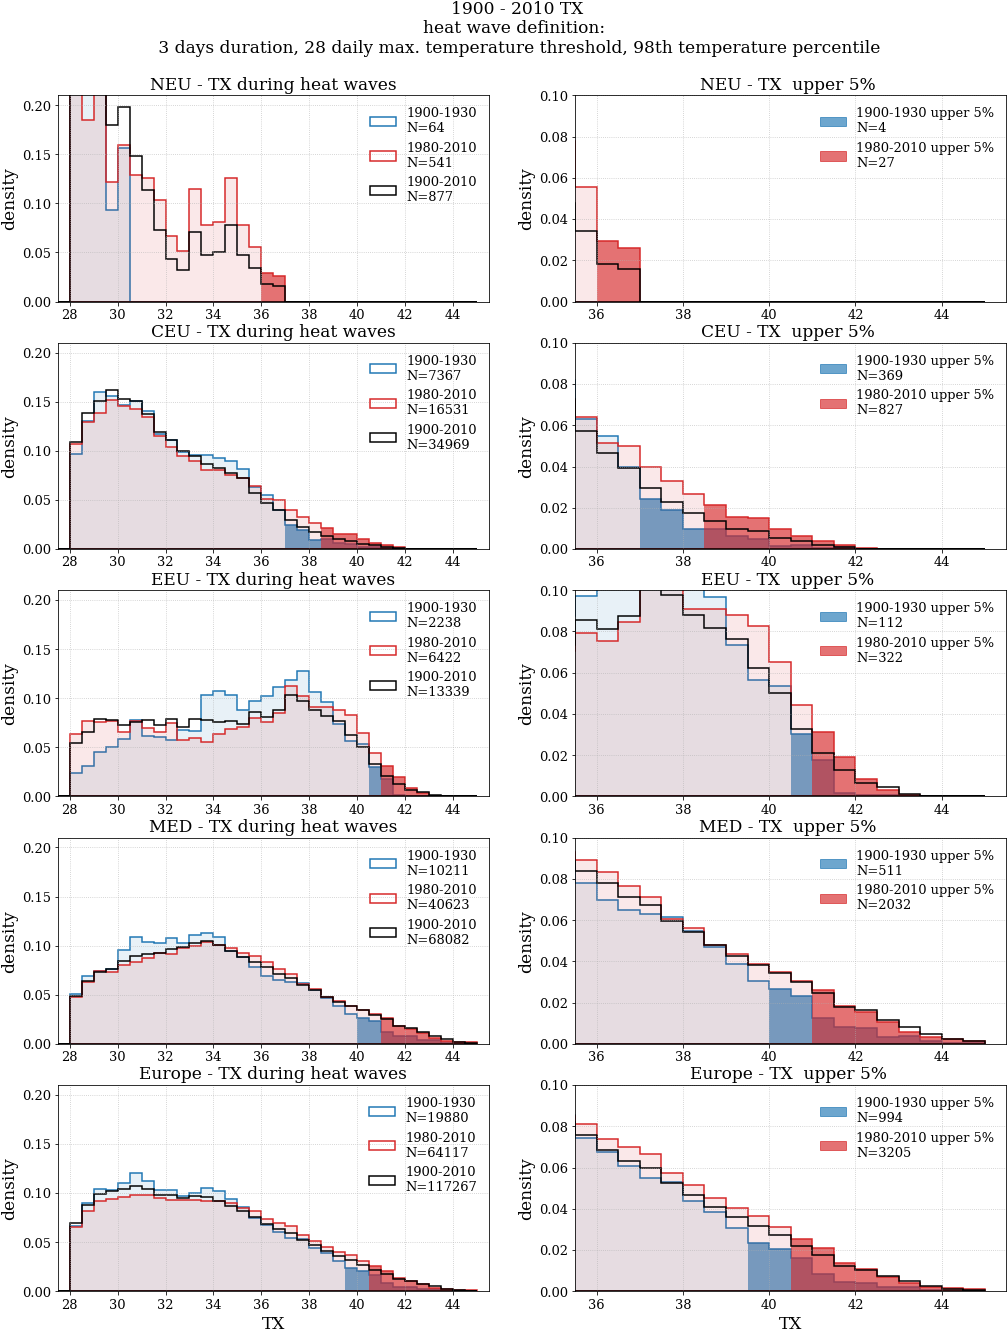

In [21]:
# ================== HISTOGRAMMS =================

regions = [('NEU', 16), ('CEU', 17) , ('EEU' , 18), ('MED' , 19), ("Europe", None)]


color = "tab:red"
header = 'mean temperature during heatwave'
ylabel = 'density'
xlabel = 'TX'
variable = "t2m"
variable_long = "TX"
binwidth = 0.5
min_bins = 27
max_bins = 45

mask = data.heatwave_mask_ydrunpctl_98_referenceperiod
land_mask = data.mask_land
year_start = data.time[0].dt.strftime("%Y").values
year_end = data.time[-1].dt.strftime("%Y").values
figure_title = year_start + " - " + year_end + " {}\nheat wave definition: \n {:.0f} days duration, {:.0f} daily max. temperature threshold, {:.0f}th temperature percentile".format(variable_long, mask.attrs["duration"], mask.attrs['threshold'], mask.attrs['quantile']*100)
variable_long

# ========== PLOT ==============
density = True
first30 = slice("1900", "1930")
last30 = slice("1980", "2010")


def plot_timeslice(ax, data, timeslice, color, upper_label = False):

    # plot first 30 years
    selected = data.sel(time = timeslice).values.flatten()
    selected = selected[~np.isnan(selected)]
    upper_percentage = np.quantile(selected, 0.95)
    number_upper = sum(selected > upper_percentage)
    number_total  = len(selected)
    bins = np.arange(min_bins, max_bins + binwidth, binwidth)
    
    if not upper_label:
        label = "{}-{}\nN={}".format(timeslice.start, timeslice.stop, number_total)
        step = ax.hist(selected, bins = bins, color = color, histtype = 'stepfilled', alpha = 1, density = True, facecolor = "None", edgecolor = color, linewidth = 1.5, label = label)
        hist = ax.hist(selected, bins = bins, color = color, histtype = 'bar', alpha = 0.1, density = density, facecolor = color) 
    else :
        label = "{}-{} upper 5%\nN={}".format(timeslice.start, timeslice.stop, number_upper)
        step = ax.hist(selected, bins = bins, color = color, histtype = 'stepfilled', alpha = 1, density = True, facecolor = "None", edgecolor = color, linewidth = 1.5)
        hist = ax.hist(selected, bins = bins, color = color, histtype = 'bar', alpha = 0.1, density = density, facecolor = color)#, label = label)

    for thispatch in hist[2]:
        if thispatch.xy[0] - binwidth/2 >= upper_percentage :
            thispatch.set_facecolor(color)
            thispatch.set_alpha(0.65)
            filled_patch = thispatch
    
    return upper_percentage, number_total, number_upper, label


def plot_sample(ax, data, upper_label = False) :
    sample = data.values.flatten()
    sample = sample[~np.isnan(sample)]
    upper_percentage = np.quantile(sample, 0.95)
    number_upper = sum(sample > upper_percentage)
    number_total  = len(sample)
    bins = np.arange(min_bins, max_bins + binwidth, binwidth)
    label = "1900-2010\nN={}".format(number_total)
    if upper_label:
        label = "1900-2010 upper 5%\nN={}".format(number_upper)
        
    N, bins, patches = ax.hist(sample, bins = bins, color = "tab:grey", histtype = 'stepfilled', alpha = 1, density = True, facecolor = "None", edgecolor = 'k', linewidth = 1.5, label = label)
    return number_total, patches


    
plt.rcParams['hatch.linewidth'] = 0.1
plt.rcParams['hatch.color'] = "k"
fig = plt.figure(figsize = (17,22)) 
fig.suptitle(figure_title, y = 0.94)
gs = gridspec.GridSpec(nrows = 5, ncols = 2)
    
idx = 0
for region in regions:

#     mask_russo = mask_russo_org.where(land_mask, other = False).where(mc.mask_region(mask_russo_org, region[1]), other = False)
    mask = data.heatwave_mask_ydrunpctl_98_referenceperiod.where(land_mask, other = False).where(mc.mask_region(mask, region[1]), other = False)

    # create the figure and the gridspecs


    ax0 = fig.add_subplot(gs[idx,0])
    ax1 = fig.add_subplot(gs[idx,1])
#     ax2 = fig.add_subplot(gs[1,0])
#     ax3 = fig.add_subplot(gs[1,1])
    # plot first 30 years 
    plot_data = data[variable].where(mask)

    first_res = plot_timeslice(ax = ax0, data = plot_data, timeslice = first30, color = "tab:blue")
    last_res = plot_timeslice(ax = ax0, data = plot_data, timeslice = last30, color = "tab:red")
    plot_sample(ax = ax0, data = plot_data)
    ax0.legend()
    first_res = plot_timeslice(ax = ax1, data = plot_data, timeslice = first30, color = "tab:blue", upper_label = True)
    last_res = plot_timeslice(ax = ax1, data = plot_data, timeslice = last30, color = "tab:red", upper_label = True)
    plot_sample(ax = ax1, data = plot_data, upper_label = True)
    patches = []
    patches.append(mpatches.Patch(color='tab:blue', alpha = 0.65, label=first_res[-1]))
    patches.append(mpatches.Patch(color='tab:red', alpha = 0.65, label=last_res[-1]))
    lgd = ax1.legend(handles=patches)
#     ax1.legend()
    
    ylim = list(ax1.get_xlim())
    ylim[0] = int(min([first_res[0], last_res[1]])) - 0.5
    ax1.set_xlim(ylim)
    ax1.set_ylim([0,0.10])
    ax0.set_ylim([0,0.21])
    ax0.set_xlim(27.5,45.5)
    ax1.set_xlim(35.5,45.5)
    ax0.set_title(region[0] + ' - ' + variable_long + ' during heat waves')

    ax1.set_title(region[0] + ' - ' + variable_long + '  upper 5% ')
#     both_variables(ax = ax1, data = data.swbgt.where(mask_russo))

#     both_variables(ax = ax2, data = hwmid.where(mask_dwd))
#     both_variables(ax = ax3, data = hwmid.where(mask_russo))

    for axs in [ax0,ax1]:
        axs.set_ylabel('density')
#         axs.set_xlabel('sWBGT')
        axs.grid()

    idx += 1
    
ax0.set_xlabel(xlabel)
ax1.set_xlabel(xlabel)

In [22]:
fig.savefig(trendfolder + 'histograms_' + variable_long + '_density_ydrunpctl_98_referenceperiod.png')

3
115
62
270
450


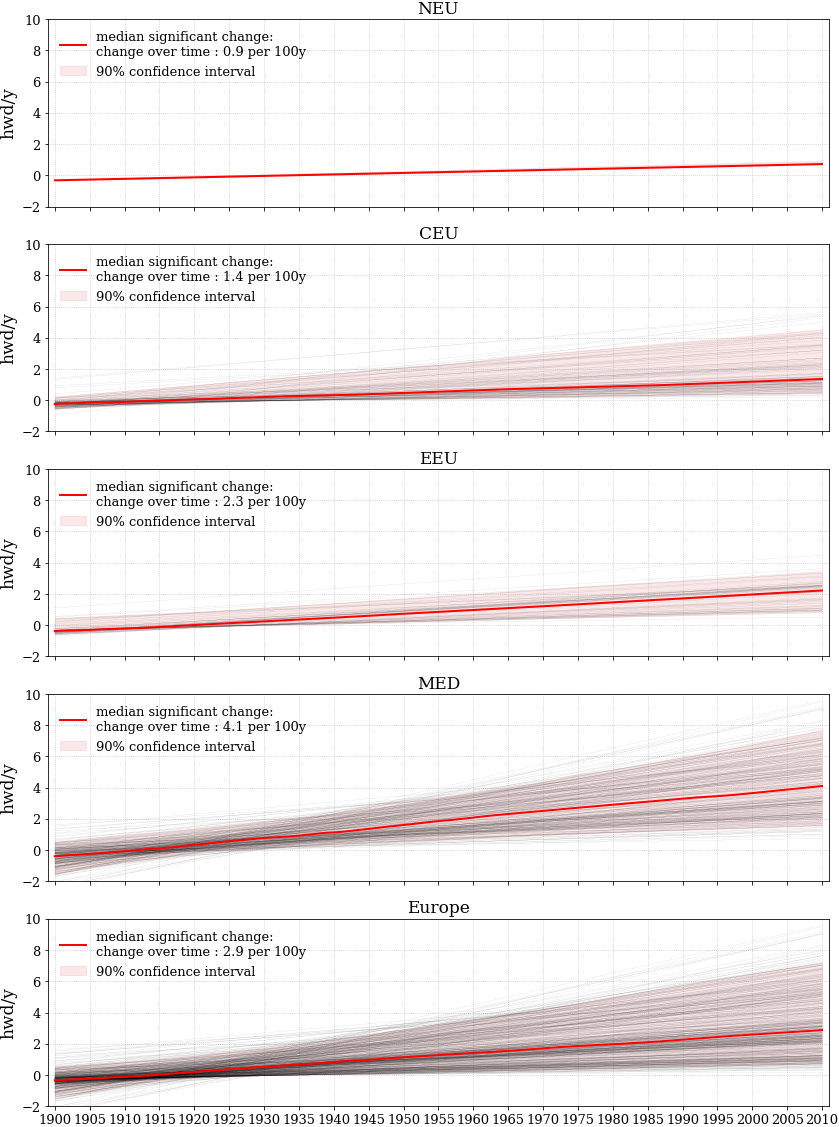

In [23]:
# ================== FILTER =================
import scipy.ndimage as ndimage
ymin = 0
ymax = 10
xmin = 1899
xmax = 2011
# filter
# b, a = signal.butter(3, 0.045)
# filter_func = lambda y : signal.filtfilt(b, a, y)
# filter_name  ='butterworth filter'

# ========== PLOT ==============
# create year range

#create figure title :
# create the figure and the gridspecs
fig, ax = plt.subplots(nrows = 5, sharex=True, figsize = (14,20)) 
# fig.suptitle(figure_title, y = 1.05)

# plot regions
def plot_region(axs, region = (None,None)):
    region_name = region[0]
    region = region[1]
    y = (data.heatwave_mask_ydrunpctl_98_referenceperiod).where(data.mask_land).where(mc.mask_region(data.area, region)).groupby('time.year').sum('time')#, min_count = 1)
    x = y.year
    
    res = trends.gufunc_linreg(x.astype(float),y, dim = 'year')
    y_linear = res['slope'] * x.astype(float) + res['intercept']
#     y_linear -= y_linear.mean('year')
#     print(y_linear)
    idx = 0
    for lat in y_linear.latitude :
        for lon in y_linear.longitude :
            if res['p_value'].sel(longitude = lon, latitude = lat) <= 0.05:
                axs.plot(x, y_linear.sel(longitude = lon, latitude = lat), color = "k", linewidth = 0.1, alpha = 0.4, linestyle = '-')#title
                idx += 1
    print(idx)
    axs.set_title(region_name)

    y_linear_mean = y_linear.where(res['p_value']<= 0.05).median({'latitude', 'longitude'})
#     y_linear_std = y_linear.where(res['p_value']<= 0.05).std({'latitude', 'longitude'})
#     axs.fill_between(x, - y_linear_std + y_linear_mean, y_linear_std + y_linear_mean, color= 'tab:red', alpha = 0.1, label = "stddev")
    y_linear_std = y_linear.where(res['p_value']<= 0.05).quantile([0.05,0.95], dim = {'latitude', 'longitude'})
    axs.fill_between(x, y_linear_std[0], y_linear_std[1], color= 'tab:red', alpha = 0.1,label = "90% confidence interval")#, label = "2 stddev")               
#     axs.plot(x, y_linear_std[1], color= 'tab:red', alpha = 0.5, )               

    axs.plot(x, y_linear_mean, color = 'red', linewidth = 2, label = 'median significant change:\nchange over time : {:.1f} per 100y'.format(100/111*(y_linear_mean[-1]-y_linear_mean[0]).values) )
    return y_linear
for idx in range(5) :
    y_linear = plot_region(ax[idx], regions[idx])
#     print(y_linear)
for axs in ax :
    
    axs.set_ylim([-2, 10])
    axs.set_xlim([xmin,xmax])
    axs.grid()
#     xcoords = [1972,2003,2010]
#     for xc in xcoords:
#         axs.axvline(x=xc, color = "tab:purple", linestyle = "--", linewidth = 1.5)
    axs.axhline(y = 0, linestyle = ":", color = 'k')
    axs.set_xticks(np.arange(xmin +1,xmax,5))
#     axs.set_yticks(np.arange(ymin, ymax +1,5))
    axs.set_ylabel('hwd/y')
    axs.legend(loc = 2)

# fig.suptitle(fig._suptitle.get_text(),fontsize = 18)

In [24]:
fig.savefig(trendfolder + 'hwdy_linear_trends_density_ydrunpctl_98_referenceperiod.png')

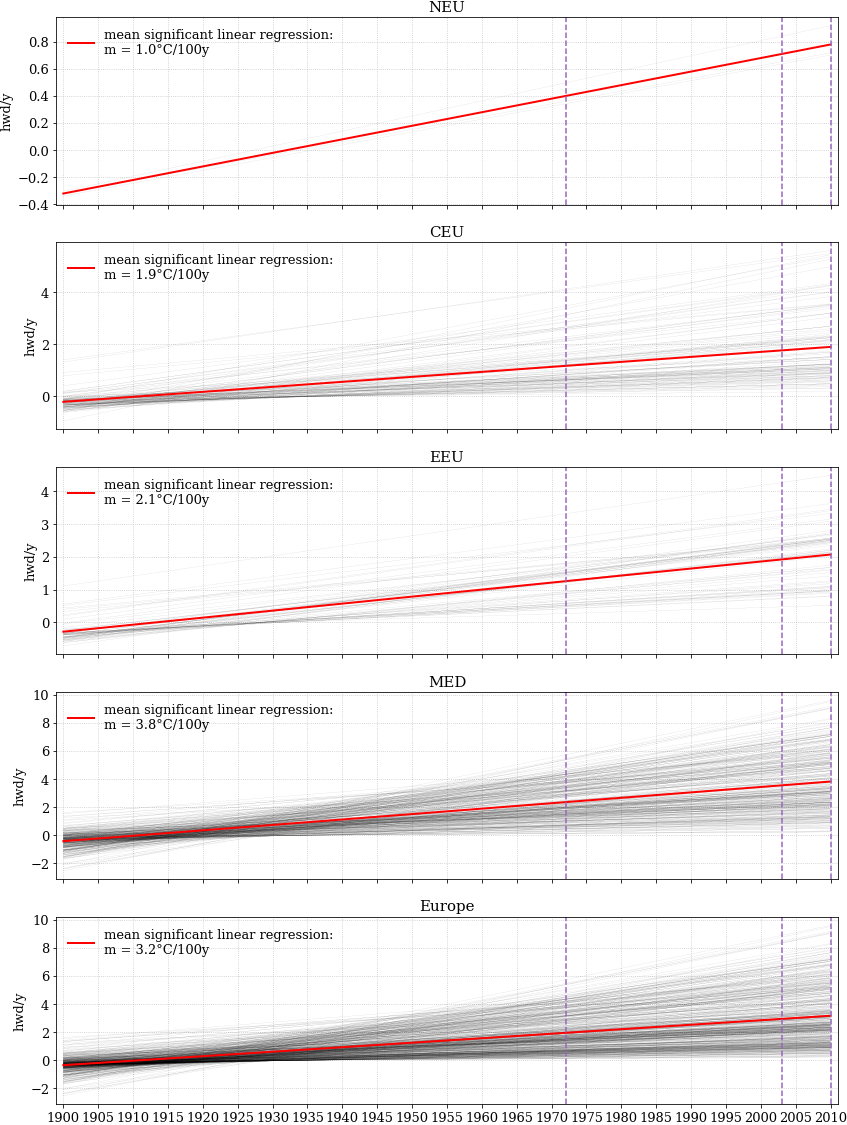

In [273]:
# ================== FILTER =================
import scipy.ndimage as ndimage
ymin = 0
ymax = 10
xmin = 1899
xmax = 2011
# filter
# b, a = signal.butter(3, 0.045)
# filter_func = lambda y : signal.filtfilt(b, a, y)
# filter_name  ='butterworth filter'

# ========== PLOT ==============
# create year range

#create figure title :
# create the figure and the gridspecs
fig, ax = plt.subplots(nrows = 5, sharex=True, figsize = (14,20)) 
# fig.suptitle(figure_title, y = 1.05)

# plot regions
def plot_region(axs, region = (None,None)):
    region_name = region[0]
    region = region[1]
    y = data.heatwave_mask_ydrunpctl_98_referenceperiod.where(mc.mask_region(data.area, region)).groupby('time.year').sum('time')
    x = y.year
    
    res = trends.gufunc_linreg(x,y, dim = 'year')
    y_linear = res['slope'] * x + res['intercept']
#     print(y_linear)
    for lat in y_linear.latitude :
        for lon in y_linear.longitude :
            if res['p_value'].sel(longitude = lon, latitude = lat) <= 0.05:
                axs.plot(x, y_linear.sel(longitude = lon, latitude = lat), color = "k", linewidth = 0.1, alpha = 0.4, linestyle = '-')#title
    axs.set_title(region_name)

    y_linear_mean = y_linear.where(res['p_value']<= 0.05).mean({'latitude', 'longitude'})
    axs.plot(x, y_linear_mean, color = 'red', linewidth = 2, label = 'mean significant linear regression:\nm = {:.1f}°C/100y'.format(100/111*(y_linear_mean[-1]-y_linear_mean[0]).values) )
    
for idx in range(5) :
    plot_region(ax[idx], regions[idx])

for axs in ax :
    
#     axs.set_ylim([ymin, ymax])
    axs.set_xlim([xmin,xmax])
    axs.grid()
#     xcoords = [1972,2003,2010]
#     for xc in xcoords:
#         axs.axvline(x=xc, color = "tab:purple", linestyle = "--", linewidth = 1.5)
    axs.set_xticks(np.arange(xmin +1,xmax,5))
#     axs.set_yticks(np.arange(ymin, ymax +1,5))
    axs.set_ylabel('hwd/y')
    axs.legend(loc = 2)

# fig.suptitle(fig._suptitle.get_text(),fontsize = 18)

In [ ]:
fig.savefig(trendfolder + 'hwdy_linear_trends_density_ydrunpctl_98_referenceperiod.png')

/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


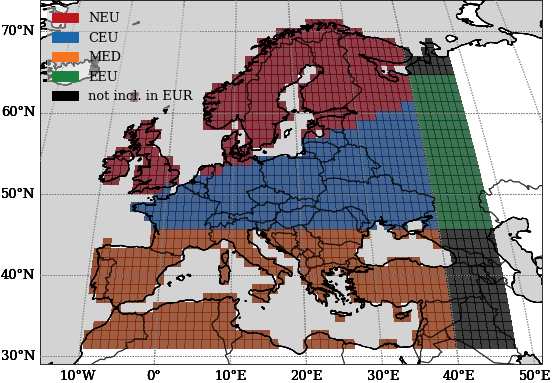

In [17]:
# plot the regions



fig = plt.figure(figsize = (9,9))
gs = gridspec.GridSpec(1, 1)

# plot the mean temperature for the heatwaves (where the mask_res is True)
ax = fig.add_subplot(gs[0,0],\
        projection=ccrs.EckertV(
#                      central_latitude=45.72,
                     central_longitude=12.5))
ax.set_extent([-17,51,29,73])
# ax.stock_img()

land_mask = data.mask_land
region_mask = mc.mask_regions(data.mask_land)

patches = []
for idx, cmap, name in [(16, 'Reds', 'NEU'), (17,'Blues', 'CEU'), (19, 'Oranges', 'MED'), (18, 'Greens', 'EEU')]:
    pm, cf = plotfunc.area_plot(ax = ax,data = land_mask.where(region_mask == idx, other = np.nan).where(land_mask), levels = [-1,0,1],cmap = cmap, pcolormesh_kwargs = dict(clim = 1, alpha = 0.75), colorbar_kwargs = dict(add_colorbar = False))
    if cmap == 'Oranges' :
        patches.append(mpatches.Patch(color=plt.get_cmap(cmap)(256-106), label=name))
    else :
        patches.append(mpatches.Patch(color=plt.get_cmap(cmap)(256-56), label=name))
# pm, cf = plotfunc.area_plot(oceancolor = False, ax = ax,data = land_mask.where(~land_mask), cmap = 'Greys', pcolormesh_kwargs = dict(alpha = 0.2, clim = 1), levels = [-1,0,1], colorbar_kwargs = dict(add_colorbar = False))
pm, cf = plotfunc.area_plot(oceancolor = False, ax = ax,data = land_mask.where((region_mask > 20) + (region_mask < 16)).where(land_mask), cmap = 'Greys', pcolormesh_kwargs = dict(alpha = 0.75, clim = 1), colorbar_kwargs = dict(add_colorbar = False), levels = [-1,0,1])

# fig.savefig(plotfolder + "regional_overview.png")
# # fig.savefig(plotfolder + "regional_overview.eps")
# fig.savefig(plotfolder + "regional_overview.svg")

# patches.append(mpatches.Patch(color='red', label='NEU'))
# patches.append(mpatches.Patch(color='blue', label='CEU'))
# patches.append(mpatches.Patch(color='orange', label='MED'))
# patches.append(mpatches.Patch(color='green', label='EEU'))
patches.append(mpatches.Patch(color='k', label='not incl. in EUR'))
# patches.append(mpatches.Patch(color='lightgrey', label='Ocean'))

rcParams_legend = {'legend.fancybox': False, 'legend.frameon': True}
plt.rcParams.update(rcParams_legend)
leg = ax.legend(handles=patches, loc = "upper left", facecolor = "lightgrey", framealpha = 0.5)
leg.set_alpha(1)
leg.set_zorder(15)
# leg.get_frame().set_edgecolor('w')
# leg.get_frame().set_facecolor([1,1,1,1])
# fig.suptitle("regional overview")
fig.savefig(plotfolder + 'regional_overview.png')


**create plot of Temperature and sWBGT trends**

In [13]:
# DEFINE THE TREND AREA PLOT FUNCTION:
# @profile    
def plot_trends(data = None, 
                mask_res = None, 
                land_mask = True,
                cmap= "cmo.thermal", cmap_trend = "cmo.balance", 
                save_name = False, 
                mask_dict = dict(), 
                dim = "year",
                projection = ccrs.PlateCarree(),
                figsize = (27,23)) :

    '''
    this function creates a figure with plotfunc.area_plot() function fro all heatwave days
    11) mean temperature 12) lin. trend where p_value < 0.05
    21) mean swbgt       22) lin. trend where p_value < 0.05
    31) days             32) lin. trend where p_value < 0.05

    INPUT:
    1. data         - xarray DataSet with longitude and latitude as dimensions
                    - !! need to include variables t2m and swbgt and dimension time, latitude, longitude
                    - !! should be daily data
    2. mask_res     - mask which is True wherever there is a heatwave occuring
    3. cmap         - cmap for temperature and swbgt
    4. cmap_days    - cmap for days of heatwave plot
    5. save_name    - if False no save else save png and svg
    6. mask_dict    - "threshold" : what was the threshold for this mask,
                    - "duration" : what was the duration
                    - "quantile" : what was the quantile provided?
    OUTPUT: 
    - figure with the plots
    '''


    # create year range
    year_start = data.time[0].dt.strftime("%Y").values
    year_end = year = data.time[-1].dt.strftime("%Y").values
    years = 31
    # get arguments for the mask (by default : NONE GIVEN)
    duration = mask_dict.setdefault("duration" , np.nan)
    threshold = mask_dict.setdefault("threshold" , np.nan)
    quantile = mask_dict.setdefault("quantile" , np.nan)
    #create figure title :
    figure_title = year_start + " - " + year_end + "\nheatwave definition: \n {:.0f} days duration, {:.0f}°C daily max. temperature threshold, {:.0f}th percentile of temperature".format(duration, threshold, quantile*100)
    # ========== PLOT ==============
    # create the figure and the gridspecs
    fig = plt.figure(figsize = figsize) 
    gs = gridspec.GridSpec(3, 2)
    fig.suptitle(figure_title)
    
    vmin_R = 0.0
    vmax_R = 0.4 
    
    print('calc temp')
    # TEMPERATURE -------------------------
    # plot the mean temperature for the heatwaves (where the mask_res is True)
    sel_data = data.t2m.where(mask_res, other = np.nan).where(land_mask)
    # CALCULATE THE LINEAR REGRESSION;
    x = (sel_data[dim] - sel_data[dim][0]).astype(float)
    linreg = trends.gufunc_linreg(x,sel_data, dim= dim)
    
    # plotdata is temp. mean
    plot_data = sel_data.mean(dim)
    ax = fig.add_subplot(gs[0,0],\
            projection=projection)
    pm, ct = plotfunc.area_plot(data= plot_data, 
                    ax = ax,
                    levels = np.arange(25, 42, 2),
                    contour_levels= np.arange(25,40,5), cmap = 'cmo.thermal',
                    landcolor = [0.4,0.4,0.4],
                    colorbar_kwargs = dict(label = "Temperature in °C"))
    
    ax.set_title("a.1) Mean temperature during a heat wave")
    
    # PLOT SLOPE
    ax = fig.add_subplot(gs[0,1],\
            projection=projection)
    plot_data = linreg["slope"]* (x[-1]-x[0])
#     print(plot_data)
#     input()
    vmin = 0
    vmax = 2
    levels = np.arange(vmin,vmax,0.25)
    pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
                    ax = ax,
                    levels = levels, cmap = cmap_trend,
                    landcolor = [0.4,0.4,0.4],
                    colorbar_kwargs = dict(divergent = True, label = "°C/110 years"))
    ax.set_title("a.2) Trend of temperature during a heat wave")
    pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] >= 0.05),
                    ax = ax, pcolormesh=False, pcolor= True,
                    levels = levels, cmap = cmap_trend,
                    colorbar_kwargs = dict(add_colorbar = False, divergent = True),
                    pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))

    print('calc swbgt')
    # SWBGT -------------------------
    # plot the mean temperature for the heatwaves (where the mask_res is True)
    sel_data = data.swbgt.where(mask_res, other = np.nan).where(land_mask)
    # CALCULATE THE LINEAR REGRESSION;
    x = (sel_data[dim] - sel_data[dim][0]).astype(float)
    linreg = trends.gufunc_linreg(x,sel_data, dim= dim)
    
    # plotdata is temp. mean
    plot_data = sel_data.mean(dim)
    ax = fig.add_subplot(gs[1,0],\
            projection=projection)
    pm, ct = plotfunc.area_plot(data= plot_data, ax = ax, \
        levels = np.arange(23, 36, 1), \
        contour_levels= np.arange(15,35,5), \
        landcolor = [0.4,0.4,0.4], cmap = plotfunc.thermal_low_extend,
        colorbar_kwargs = dict(label = "sWBGT"))
    
    ax.set_title("b.1) Mean sWBGT during heat wave")
    
    # lot slope
    ax = fig.add_subplot(gs[1,1],\
            projection=projection)

    ax.coastlines(resolution='110m')
    ax.gridlines()
    plot_data = linreg["slope"]* (x[-1]-x[0])
    vmin = 0
    vmax = 2
    levels = np.arange(vmin,vmax,0.25)
    pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
                    ax = ax,
                    levels = levels, cmap = cmap_trend,
                    landcolor = [0.4,0.4,0.4],
                    colorbar_kwargs = dict(divergent = True, label = "1/110 years"))
    ax.set_title("a.2) Trend of temperature during a heat wave")
    pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] >= 0.05),
                    ax = ax, pcolormesh=False, pcolor= True,
                    levels = levels, cmap = cmap_trend,
                    colorbar_kwargs = dict(add_colorbar = False, divergent = True),
                    pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))
    
    ax.set_title("b.2) Trend of sWBGT during a heat wave")
    
    print('calc days')
    # DAYS per YEAR  -------------------------
    # plot the mean temperature for the heatwaves (where the mask_res is True)
    
    # CALCULATE THE LINEAR REGRESSION;
    sel_data = mask_res.where(land_mask).groupby('time.year').sum("time").where(land_mask)
#     sel_data = sel_data.where(land_mask)
    x = (sel_data["year"] - sel_data["year"][0]).astype(float)
    linreg = trends.gufunc_linreg(x,sel_data, dim= "year")
    
    # plot days per year
    plot_data = sel_data.mean("year")
    mask_plot = plot_data > 0
    plot_data = plot_data.where(mask_plot, other = np.nan)
    ax = fig.add_subplot(gs[2,0],\
            projection=projection)


    pm, ct = plotfunc.area_plot(data= plot_data, ax = ax, \
        levels = np.arange(0,6,0.5), \
        cmap = 'cmo.matter',
        landcolor = [0.4,0.4,0.4],
        colorbar_kwargs = dict(label = "days per year"))
    ax.set_title("c.1) Mean days part of a heatwave per year")

    # PLOT SLOPE with according hogher linreg["p_value"]s
    ax = fig.add_subplot(gs[2,1],\
            projection=projection)
    plot_data = linreg["slope"]* (x[-1]-x[0])
    plot_data = plot_data.where(plot_data != 0)
    vmin = 0
    vmax = np.round(plot_data.max(), decimals = 0)
    levels = np.arange(vmin,vmax+1,2)
    pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] < 0.05),
                    ax = ax,
                    levels = levels, cmap = cmap_trend,
                    landcolor = [0.4,0.4,0.4],
                    colorbar_kwargs = dict(divergent = True, label = "days/110 years"))
    ax.set_title("a.2) Trend of temperature during a heat wave")
    pm, ct = plotfunc.area_plot(data= plot_data.where(linreg["p_value"] >= 0.05),
                    ax = ax, pcolormesh=False, pcolor= True,
                    levels = levels, cmap = cmap_trend,
                    colorbar_kwargs = dict(add_colorbar = False, divergent = True),
                    pcolormesh_kwargs=dict(hatch = "////", alpha = 0.4))
    
    ax.set_title("c.2) Trend of yearly heat wave days")
    
    print('DONE')
    del plot_data, sel_data, linreg, data, mask_res
    return fig


*exceute above function*

calc temp
calc swbgt
calc days
DONE
16.417986631393433


/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  # Remove the CWD from sys.path while we load stuff.
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


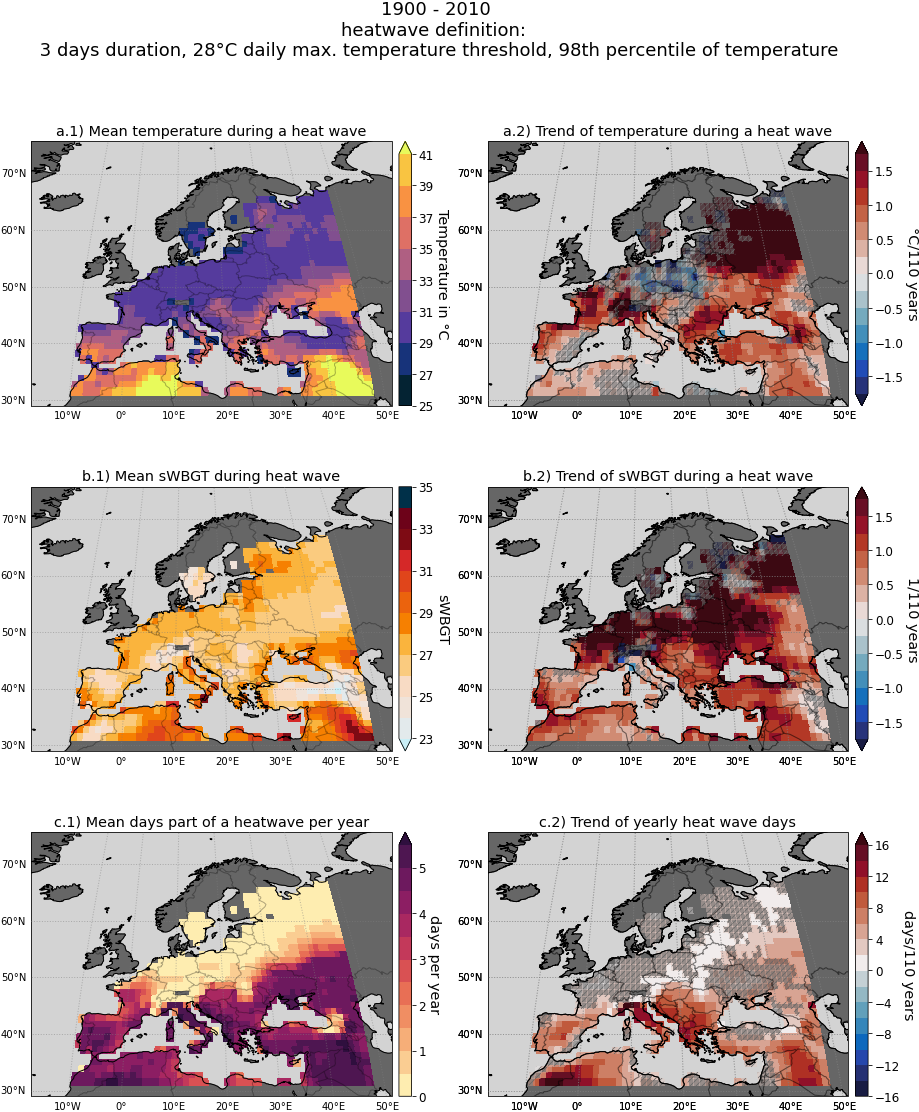

In [14]:

plt.rcParams["hatch.color"] = [0.4,0.4,0.4]
plt.rcParams["hatch.linewidth"] = 0.75
st = time.time()
fig1 = plot_trends(data.where(data.mask_land), mask_res=data.heatwave_mask_ydrunpctl_98_referenceperiod.where(data.mask_land), dim = "time",
        projection=ccrs.EckertV(central_longitude=12.5),
#         cmap_trend = 'bwr',
        mask_dict = dict(threshold = threshold, duration = duration, quantile = quantile),
                  figsize = (15,18))
print(time.time() - st)
fig1.tight_layout()
fig1.suptitle(fig1._suptitle.get_text(),fontsize = 18)

fig1.set_size_inches(15, 18)
fig1.canvas.draw()
fig1.savefig(trendfolder + "fulltime_sign_trends.png")
# fig1.savefig(trendfolder + "fulltime_trends.pdf")

In [ ]:
regions = [('NEU', 16), ('CEU', 17) , ('EEU' , 18), ('MED' , 19), ("Europe", None)]

threshold = 25
duration = 3
quantile = 0.98
min_count = 1
variable = "t2m"
variable_long = "temperature in °C"


mask = (data.heatwave_mask_ydrunpctl_98_referenceperiod) & (data.swbgt >= data.swbgt.quantile(0.98, dim = 'time'))
land_mask = data.mask_land
year_start = data.time[0].dt.strftime("%Y").values
year_end = data.time[-1].dt.strftime("%Y").values
figure_title = year_start + " - " + year_end + "\nheatwave definition: \n {:.0f} days duration, {:.0f} daily max. {} threshold, {:.0f}th percentile of {}".format(mask.attrs["duration"], mask.attrs['threshold'], variable_long, mask.attrs['quantile']*100, variable_long)

def calc_weighted_values(array, area):
    weight = area/area.mean()
    return (array*weight)
    


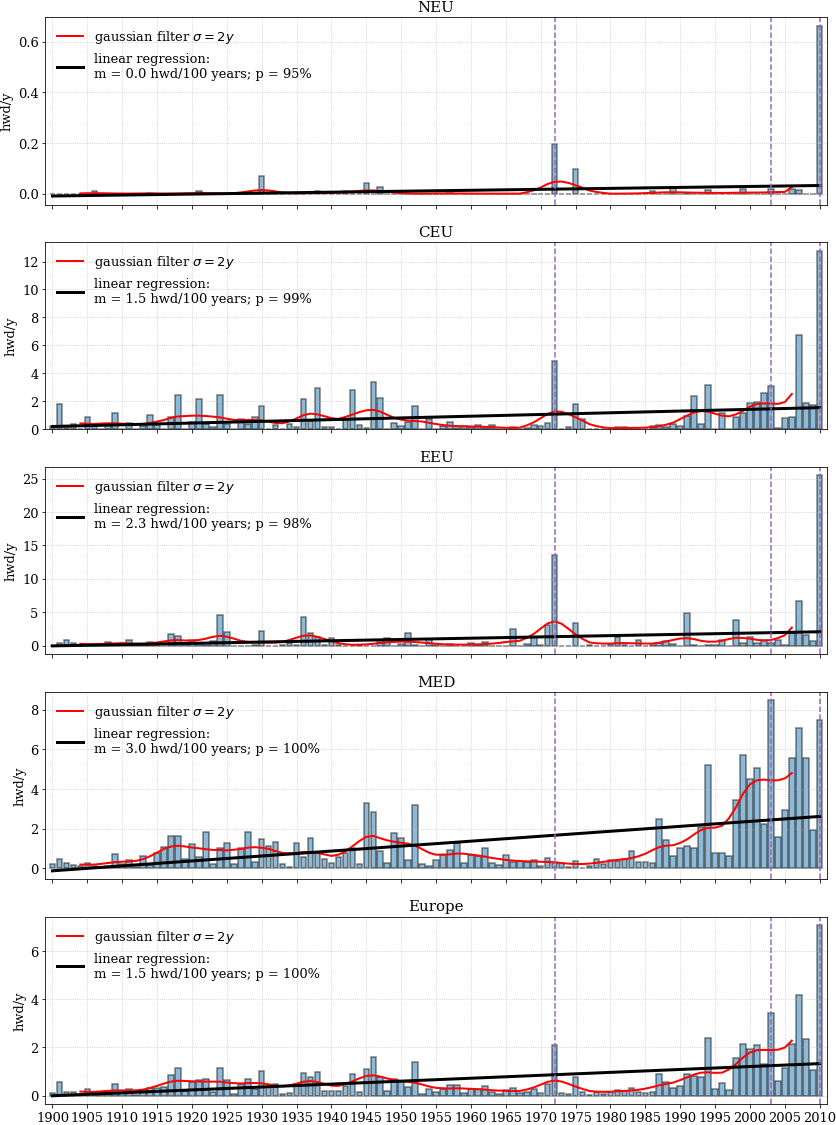

In [155]:
# ================== FILTER =================
import scipy.ndimage as ndimage
ymin = 0
ymax = 10
xmin = 1899
xmax = 2011
# filter
# b, a = signal.butter(3, 0.045)
# filter_func = lambda y : signal.filtfilt(b, a, y)
# filter_name  ='butterworth filter'

filter_func = lambda y : ndimage.gaussian_filter(y, sigma=2.0, truncate=2.0, mode='constant', cval=np.nan)
filter_name = r"gaussian filter $\sigma = 2 y$"
# filter_func = lambda y : signal.savgol_filter(y, window_length = 51, polyorder = 3, delta= 2, mode = "interp")
# filter_name  ='savgol_filter'

# ========== PLOT ==============
# create year range

#create figure title :
# create the figure and the gridspecs
fig, ax = plt.subplots(nrows = 5, sharex=True, figsize = (14,20)) 
# fig.suptitle(figure_title, y = 1.05)

# plot regions
def plot_region(axs, region = (None,None)):
    region_name = region[0]
    region = region[1]
    y = (data.heatwave_mask_ydrunpctl_98_referenceperiod).where(mc.mask_region(data.area, region)).groupby('time.year').sum('time', min_count = 1)
    y_mean = y.mean({'latitude','longitude'})#/((data.population_total*1e-6).where(mc.mask_region(data.population_total, 16)).sum({'latitude','longitude'}))
    
#     y = data.area.where(mask & land_mask & mc.mask_region(mask, region)).groupby('time.year').sum("time", min_count = 3)
    x = y_mean.year
#     y_stddev = calc_weighted_values(y, data.area).std({'latitude','longitude'})
#     y_mean = calc_weighted_values(y, data.area).mean({'latitude','longitude'})
#     y_mean[np.isnan(y_mean)] = 0    
    # mean
    axs.bar(x, y_mean, color = 'tab:blue', alpha = 0.5, edgecolor = "k", linewidth = 1.5) #, yerr= y_stddev, error_kw = dict(elinewidth = 3, marker = "o", linestyle = '-', alpha = 0.35, ecolor = 'k'), label = "days")
    # filtered data 
    yhat = filter_func(y_mean)
    axs.plot(x, yhat, color = "red", linewidth = 2, linestyle = '-', label = filter_name )
    # linreg
    res = trends.gufunc_linreg(x,y_mean, dim = 'year')
    y_linear = res['slope'] * x + res['intercept']
    axs.plot(x, y_linear, color = "k", linewidth = 3, linestyle = '-', label = 'linear regression:\nm = {:.1f} hwd/100 years; p = {:.0f}%'.format((y_linear[-1] - y_linear[0]).values * 110/100, (1 - res['p_value'].values)*100) )
    #title
    axs.set_title(region_name)


for idx in range(5) :
    plot_region(ax[idx], regions[idx])

for axs in ax :
    
#     axs.set_ylim([ymin, ymax])
    axs.set_xlim([xmin,xmax])
    axs.grid()
    xcoords = [1972,2003,2010]
    for xc in xcoords:
        axs.axvline(x=xc, color = "tab:purple", linestyle = "--", linewidth = 1.5)
    axs.set_xticks(np.arange(xmin +1,xmax,5))
#     axs.set_yticks(np.arange(ymin, ymax +1,5))
    axs.set_ylabel('hwd/y')
    axs.legend(loc = 2)

# fig.suptitle(fig._suptitle.get_text(),fontsize = 18)

In [156]:
fig.savefig(trendfolder + 'heatwavedays_ydrunctl98_referenceperiod_trends_mean')


/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/nniebaum/miniconda3/envs/py3_std/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


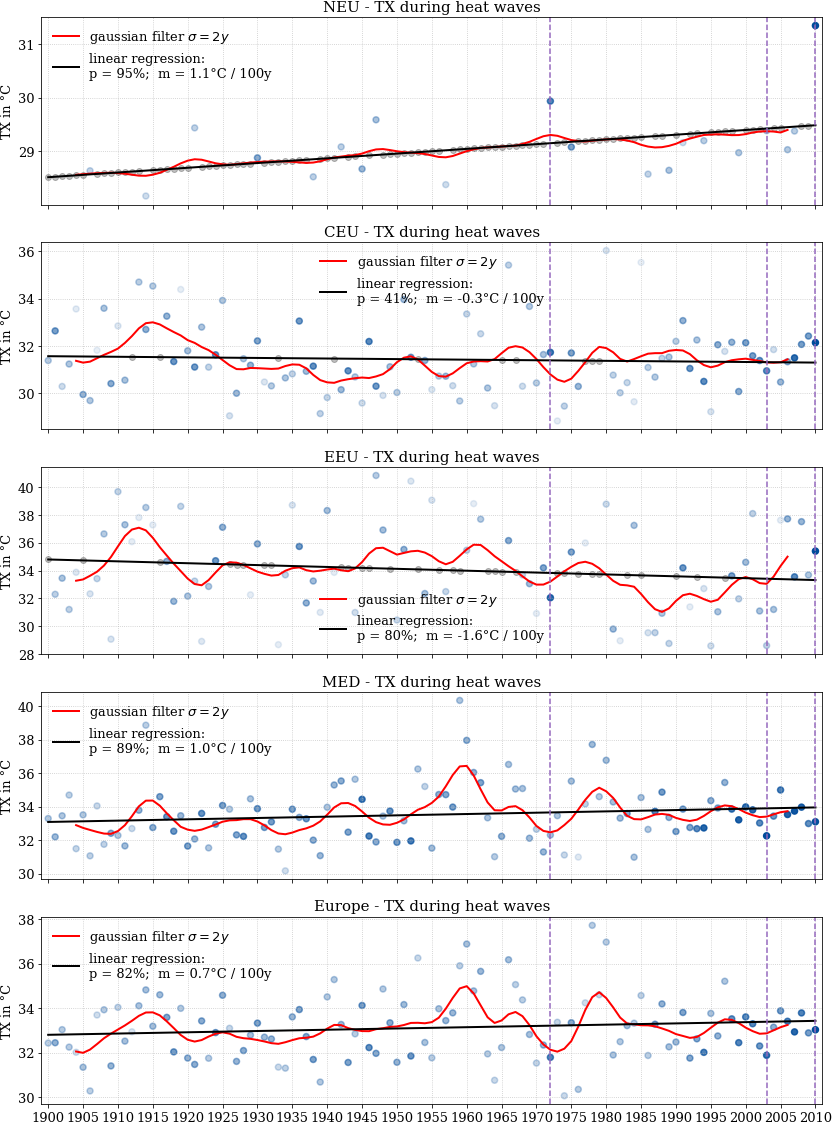

In [165]:
header = 'TX during heat waves'
ylabel = 'TX in °C'
label = 'TX in °C'
variable = "t2m"

# header = 'sWBGTX during heat waves'
# ylabel = 'sWBGTX'
# label = 'sWBGTX'
# variable = "swbgt"

# color = "tab:orange"
# header = 'mean sWBGT during heatwave'
# ylabel = 'sWBGT in °C'
# label = 'sWBGT in °C'
# variable = "swbgt"

mask = data.heatwave_mask_ydrunpctl_98_referenceperiod
land_mask = data.mask_land
year_start = data.time[0].dt.strftime("%Y").values
year_end = data.time[-1].dt.strftime("%Y").values
figure_title = year_start + " - " + year_end + "\nheatwave definition: \n {:.0f} days duration, {:.0f} daily max. temperature threshold, {:.0f}th percentile of temperature".format(mask.attrs["duration"], mask.attrs['threshold'], mask.attrs['quantile']*100)


xmin = 1899
xmax = 2011

select_summer = lambda x : x.where((x.time.dt.month >= 7) & (x.time.dt.month <= 8)) 
# filter
# b, a = signal.butter(3, 0.045)
# filter_func = lambda y : signal.filtfilt(b, a, y)
# filter_name  ='butterworth filter'

filter_func = lambda y : ndimage.gaussian_filter(y, sigma=2.0, truncate=2.0, mode='constant', cval=np.nan)
filter_name = r"gaussian filter $\sigma = 2 y$"
# filter_func = lambda y : signal.savgol_filter(y, window_length = 51, polyorder = 3, delta= 2, mode = "interp")
# filter_name  ='savgol_filter'

y_lambda_calc = lambda y: y.groupby('time.year').mean("time")


# ========== PLOT ==============

# create the figure and the gridspecs
fig, ax = plt.subplots(nrows = 5, sharex=True, figsize = (14,20)) 
# fig.suptitle(figure_title, y = 1.05)

# plot regions
def plot_region(axs, region = (None,None)):
    region_name = region[0]
    region = region[1]
    y = (data[variable].where(data.heatwave_mask_ydrunpctl_98_referenceperiod)).where(mc.mask_region(data.area, region)).groupby('time.year').mean('time')#, min_count = 1)
    alpha = (data.heatwave_mask_ydrunpctl_98_referenceperiod.where(mc.mask_region(data.area, region)).groupby('time.year').sum('time', min_count = 3).sum({'latitude', 'longitude'}).values)**(1/3)
    x = y.year
    y_stddev = y.std({'latitude','longitude'})
    y_mean = y.mean({'latitude','longitude'})
    
#     alphas = np.linspace(0.1, 1, 10)
    rgba_colors = np.zeros((len(alpha),4))
    # for red the first column needs to be one
    rgba_colors[:,0] = 0/255
    rgba_colors[:,1] = 75/255
    rgba_colors[:,2] = 155/255
    # the fourth column needs to be your alphas
    rgba_colors[:, 3] = alpha/max(alpha)

#     plt.scatter(x, y, color=rgba_colors)

    # mean
    axs.scatter(x, y_mean, color = rgba_colors, marker = 'o', linewidth = 1.5)
    # stddev
#     axs.fill_between(x, - y_stddev + y_mean, y_stddev + y_mean, color= color, alpha = 0.1, label = "stddev")
#     axs.fill_between(x, - 2*y_stddev + y_mean, 2*y_stddev + y_mean, color= color, alpha = 0.05, label = "2 stddev")               
    # filtered data
    # linreg
    res = trends.gufunc_linreg(x,y_mean, dim = 'year')
    y_linear = res['slope'] * x + res['intercept']
    # calculate summer mean to replace the years without heatwave days
    axs.plot(x[np.isnan(y_mean)], x[np.isnan(y_mean)]* 0 + y_linear, color = 'k', marker = 'o', linestyle = '', alpha = 0.25, linewidth = 1.5)
    y_mean[np.isnan(y_mean)] = y_linear[np.isnan(y_mean)]
    yhat = filter_func(y_mean)
    axs.plot(x, yhat, color = "red", linewidth = 2, linestyle = '-', label = filter_name )
    # temp
    axs.plot(x,y_linear, color = "k", linewidth = 2, linestyle = '-', label = 'linear regression:\np = {:.0f}%;  m = {:.1f}°C / 100y'.format((1 - res['p_value'].values)*100, (y_linear[-1] - y_linear[0]).values * 110/100))
    #swbgtx
#     axs.plot(x,y_linear, color = "k", linewidth = 2, linestyle = '-', label = 'linear regression:\np = {:.0f}%;  m = {:.1f} / 100y'.format((1 - res['p_value'].values)*100, (y_linear[-1] - y_linear[0]).values * 110/100))    
    
    #title
    axs.set_title(region_name +' - '+ header)


for idx in range(5) :
    plot_region(ax[idx], regions[idx])

for axs in ax :
#     ymin, ymax = axs.get_ylim()
    axs.set_xlim([xmin,xmax])
#     axs.set_ylim([17,40])
    axs.grid()
    xcoords = [1972,2003,2010]
    for xc in xcoords:
        axs.axvline(x=xc, color = "tab:purple", linestyle = "--", linewidth = 1.5)
    axs.set_xticks(np.arange(xmin +1,xmax,5))
#     axs.set_yticks(np.arange(18, 42,2))
    axs.set_ylabel(ylabel)
    axs.legend(loc='best', fancybox=True)
    

# fig.tight_layout()
# fig.suptitle(fig._suptitle.get_text(),fontsize = 18)

In [166]:
# ' SAVE FIGURE'
fig.savefig(trendfolder + 'TX_ydrunpctl_98_referenceperiod_trends')

***REST***

Text(0.5, 0.98, '1900 - 2010\nheatwave definition: \n based on Russo et al. : HWMId > 0 and duration of 3 days')

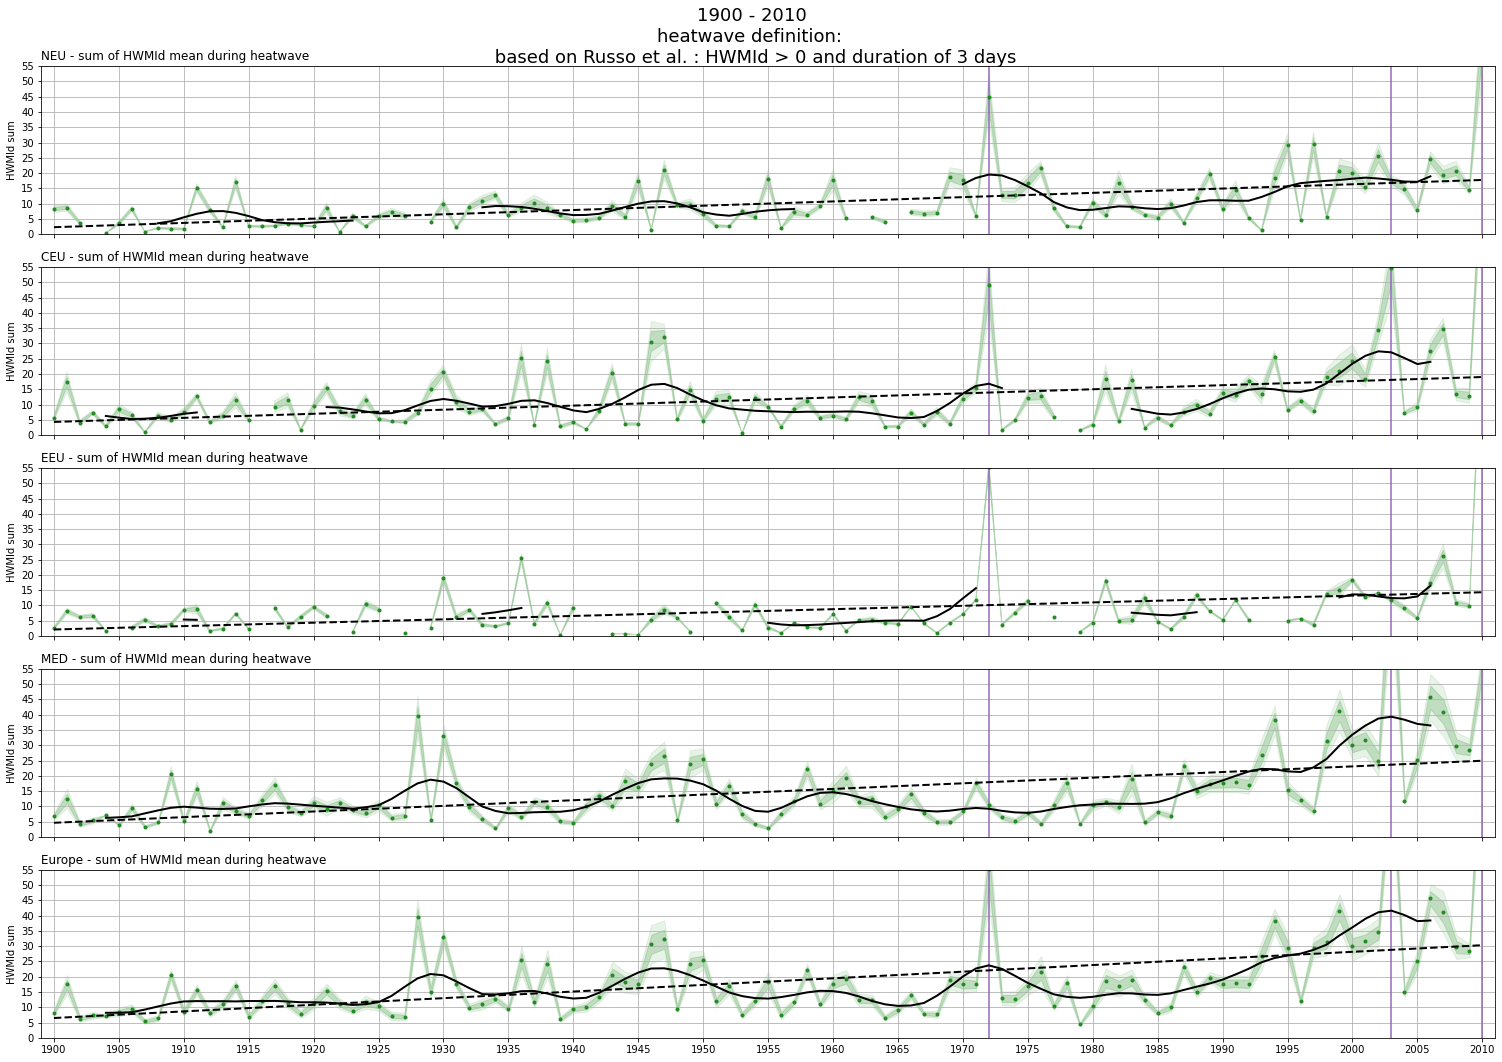

In [44]:

color = "forestgreen"
header = 'sum of HWMId mean during heatwave'
label = 'HWMId sum'

# filter
b, a = signal.butter(3, 0.045)
# filter_func = lambda y : signal.filtfilt(b, a, y)
# filter_name  ='butterworth filter'

filter_func = lambda y : ndimage.gaussian_filter(y, sigma=2.0, truncate=2.0, mode='constant', cval=np.nan)
filter_name = "gauss"
# filter_func = lambda y : signal.savgol_filter(y, window_length = 51, polyorder = 3, delta= 2, mode = "interp")
# filter_name  ='savgol_filter'

y_lambda_calc = lambda y: y.groupby('time.year').sum("time", min_count = min_count)


# ========== PLOT ==============
# create year range
year_start = data.time[0].dt.strftime("%Y").values
year_end = data.time[-1].dt.strftime("%Y").values
#create figure title :
figure_title = year_start + " - " + year_end + "\nheatwave definition: \n based on Russo et al. : HWMId > 0 and duration of 3 days"
# create the figure and the gridspecs
fig, ax = plt.subplots(nrows = 5, sharex=True, figsize = (21,15)) 
fig.suptitle(figure_title)


# plot regions
def plot_region(axs, region = (None,None)):
    region_name = region[0]
    region = region[1]
# 'HWMId'
    y = y_lambda_calc(hwmid.where(mask & land_mask & mc.mask_region(mask, region)))#, min_count = min_count)
# # 'sWBGT'
#     y = y_lambda_calc(data.swbgt.where(hwmid >0).where(mask & land_mask & mc.mask_region(mask, region)))#, min_count = min_count)

    x = y.year
    y_stddev = y.std('latitude').std('longitude')
    y_mean = y.max('latitude').max('longitude')
    # mean
    axs.plot(x, y_mean, linestyle ='', marker = '.', label = "HWMId", color = color)
    # stddev
    axs.fill_between(x, - y_stddev + y_mean, y_stddev + y_mean, color= color, alpha = 0.2, label = "stddev")
    axs.fill_between(x, - 2*y_stddev + y_mean, 2*y_stddev + y_mean, color= color, alpha = 0.1, label = "2 stddev")
#     axs.plot(x, - y_stddev + y_mean, color= 'k', linestyle = ':')
    
    #smooth
#     yhat = signal.savgol_filter(y_mean.where(y_mean != np.nan), window_length = 51, polyorder = 3, delta= 2, mode = "interp")
    yhat = filter_func(y_mean)
    axs.plot(x, yhat, color = "k", linewidth = 2, linestyle = '-', label = filter_name )
    
    # linreg
    res = trends.gufunc_linreg(x,y_mean, dim = 'year')
    axs.plot(x,res['slope'] * x + res['intercept'], color = "k", linewidth = 2, linestyle = '--', label = 'lin reg R2 = {:.2f}'.format((res['r_value'].values**2)))
    axs.set_title(region_name + ' - ' + header, loc = 'left')


for idx in range(4) :
    plot_region(ax[idx], regions[idx])
    
# plot whole data 
region_name = "Europe"

# 'HWMId'
y = y_lambda_calc(hwmid.where(mask & land_mask & (mc.mask_region(mask, 16) + mc.mask_region(mask, 17) + mc.mask_region(mask, 18) +mc.mask_region(mask, 19))))
# # 'sWBGT'
# y = y_lambda_calc(data.swbgt.where(hwmid >0).where(mask & land_mask & (mc.mask_region(mask, 16) + mc.mask_region(mask, 17) + mc.mask_region(mask, 18) +mc.mask_region(mask, 19))))#, min_count = min_count)


x = y.year
y_stddev = y.std('latitude').std('longitude')
y_mean = y.max('latitude').max('longitude')
# mean
ax[-1].plot(x, y_mean, linestyle ='', marker = '.', label = "days", color = color)
# stddev
ax[-1].fill_between(x, - y_stddev + y_mean, y_stddev + y_mean, color= color, alpha = 0.2, label = "stddev")
ax[-1].fill_between(x, - 2*y_stddev + y_mean, 2*y_stddev + y_mean, color= color, alpha = 0.1, label = "2 stddev")
#     axs.plot(x, - y_stddev + y_mean, color= 'k', linestyle = ':')

#smooth
yhat = filter_func(y_mean)
ax[-1].plot(x, yhat, color = "k", linewidth = 2, linestyle = '-', label = filter_name)

# linreg
res = trends.gufunc_linreg(x,y_mean, dim = 'year')
ax[-1].plot(x,res['slope'] * x + res['intercept'], color = "k", linewidth = 2, linestyle = '--', label = 'lin reg R2 = {:.2f}'.format((res['r_value'].values**2)))
ax[-1].set_title('Europe - ' + header, loc = 'left')


for axs in ax :
    ymin = 0
    ymax = 55
    xmin = min(x) -1
    xmax = max(x) +1
    
    axs.set_ylim([ymin, ymax])
    axs.set_xlim([xmin,xmax])
    axs.grid()
    axs.vlines([1972,2003,2010],ymin, ymax, color = "tab:purple", linestyle = "-", linewidth = 1.5)
    axs.set_xticks(np.arange(xmin +1,xmax,5))
    axs.set_yticks(np.arange(ymin, ymax +1,5))
    axs.set_ylabel(label)
#     axs.legend(loc = 2)
fig.tight_layout()
fig.suptitle(fig._suptitle.get_text(),fontsize = 18)


In [7]:
# ================== HISTOGRAMMS =================


regions = [("EUR", None),('NEU', 16), ('CEU', 17) , ('EEU' , 18), ('MED' , 19) ]

color = "tab:red"
header = 'mean temperature during heatwave'
ylabel = 'temperature in °C'
label = 'temperature in °C'
variable = "t2m"

mask = data.heatwave_mask_ydrunpctl_98_referenceperiod
land_mask = data.mask_land
year_start = data.time[0].dt.strftime("%Y").values
year_end = data.time[-1].dt.strftime("%Y").values
figure_title = year_start + " - " + year_end + "\nheatwave definition: \n {:.0f} days duration, {:.0f} daily max. {} threshold, {:.0f}th percentile of {}".format(mask.attrs["duration"], mask.attrs['threshold'], variable_long, mask.attrs['quantile']*100, variable_long)


# ========== PLOT ==============
density = True
first30 = slice("1900", "1930")
last30 = slice("1980", "2010")

for region in regions:
    figure_title = "Density distribution of sWBGT and HWMId during heat waves over " + region[0]


    mask_russo = mask_russo_org.where(land_mask, other = False).where(mc.mask_region(mask_russo_org, region[1]), other = False)
    mask_dwd = mask_dwd_org.where(land_mask, other = False).where(mc.mask_region(mask_dwd_org, region[1]), other = False)

    # create the figure and the gridspecs
    plt.rcParams['hatch.linewidth'] = 0.1
    plt.rcParams['hatch.color'] = "k"
    fig = plt.figure(figsize = (15,10)) 
    fig.suptitle(figure_title)
    gs = gridspec.GridSpec(nrows = 2, ncols = 2)

    ax0 = fig.add_subplot(gs[0,0])
    ax1 = fig.add_subplot(gs[0,1])
    ax2 = fig.add_subplot(gs[1,0])
    ax3 = fig.add_subplot(gs[1,1])
    # plot first 30 years 

    def both_variables(ax, data):

        # plot first 30 years
        first = data.sel(time = first30).values.flatten()
        first = first[~np.isnan(first)]
        ax.hist(first, bins = 50, color = "tab:blue", histtype = 'stepfilled', alpha = 1, density = denisty, facecolor = "None", edgecolor = 'tab:blue', linewidth = 1.5, label = "1900-1930\nN={}".format(len(first)))
        ax.hist(first, bins = 50, color = "tab:blue", histtype = 'bar', alpha = 0.15, density = density, facecolor = "tab:blue", hatch= "\\\\\\" ) 

        mean = np.mean(first)
        stddev = np.std(first)
        ax.axvline(mean, color = "w", linestyle = '-', linewidth = 3)
        ax.axvline(mean, color = "tab:blue", linestyle = '-', linewidth = 2)
        ax.axvspan(mean-stddev, mean+stddev, facecolor=[0.1,0.1,0.7,0.1], edgecolor = "tab:blue", linestyle = '--', linewidth = 1)

        # plot last 30 years
        last = data.sel(time = last30).values.flatten()
        last = last[~np.isnan(last)]
        ax.hist(last, bins = 50, color = "tab:red", histtype = 'stepfilled', alpha = 1, density = density, facecolor = "None", edgecolor = 'tab:red', linewidth = 1.5, label = "1980-2010\nN={}".format(len(last)))
        ax.hist(last, bins = 50, color = "tab:red", histtype = 'bar', alpha = 0.1, density = density, facecolor = "tab:red", hatch = "///")

        mean = np.mean(last)
        stddev = np.std(last)
        ax.axvline(mean, color = "w", linestyle = '-', linewidth = 3)
        ax.axvline(mean, color = "tab:red", linestyle = '-', linewidth = 2)
        ax.axvspan(mean-stddev, mean+stddev, facecolor=[0.7,0.1,0.1,0.07], edgecolor = "tab:red", linestyle = '--', linewidth = 1)

        #samples
        sample = data.values.flatten()
        sample = sample[~np.isnan(sample)]
    #     import random
    #     my_randoms = random.sample(range(len(sample)), 10000)
    #     sample = sample[my_randoms]
        ax.hist(sample, bins = 50, color = "tab:grey", histtype = 'stepfilled', alpha = 1, density = density, facecolor = "None", edgecolor = 'k', linewidth = 1.5, label = "1900-2010\nN={}".format(len(sample)))

        ax.legend()

    both_variables(ax = ax0, data = data.swbgt.where(mask_dwd))
    both_variables(ax = ax1, data = data.swbgt.where(mask_russo))

    both_variables(ax = ax2, data = hwmid.where(mask_dwd))
    both_variables(ax = ax3, data = hwmid.where(mask_russo))

    for axs in [ax0,ax1]:
        axs.set_ylabel('density')
        axs.set_xlabel('sWBGT')
        axs.grid()

    for axs in [ax2,ax3]:
        axs.set_ylabel('density')
        axs.set_xlabel('HWMId')
        axs.grid()


    ax0.set_title("similar to DWD: \n{:.0f} days duration, {:.0f} daily max. {} threshold,\n {:.0f}th percentile of {}".format(duration, threshold, variable_long, quantile*100, variable_long))
    ax1.set_title('similar to Russo et. al 2015: \nHWMId > 0 duration 3 days duration')


    fig.savefig(trendfolder + "histograms_density_{}.png".format(region[0]))
    fig.savefig(trendfolder + "histograms_density_{}.svg".format(region[0]))